양방향 다층 신경망, LSTM 등을 사용한 감정 분석 모델을 구현해보았다.

# 1. 양방향 다층 신경망

In [1]:
import torch
from torch import nn

input_size = 128
ouput_size = 256
num_layers = 3
bidirectional = True # 양방향

model = nn.RNN(
    input_size=input_size,
    hidden_size=ouput_size,
    num_layers=num_layers,
    nonlinearity="tanh",
    batch_first=True,
    bidirectional=bidirectional,
)

batch_size = 4
sequence_len = 6

inputs = torch.randn(batch_size, sequence_len, input_size)
h_0 = torch.rand(num_layers * (int(bidirectional) + 1), batch_size, ouput_size) # 초기 hidden state

outputs, hidden = model(inputs, h_0) # forward
print(outputs.shape)
print(hidden.shape)

torch.Size([4, 6, 512])
torch.Size([6, 4, 256])


inputs과 초기 hidden state로 순방향 연산을 수행해 ouputs과 최종 hidden state를 반환한다.

# 2. 양방향 다층 LSTM

In [2]:
import torch
from torch import nn


input_size = 128
output_size = 256
num_layers = 3
bidirectional = True
proj_size = 64

model = nn.LSTM(
    input_size=input_size,
    hidden_size=output_size,
    num_layers=num_layers,
    batch_first=True,
    bidirectional=bidirectional,
    proj_size=proj_size,
)

batch_size = 4
sequence_len = 6

inputs = torch.randn(batch_size, sequence_len, input_size)
h_0 = torch.rand(
    num_layers * (int(bidirectional) + 1),
    batch_size,
    proj_size if proj_size > 0 else output_size,
)
c_0 = torch.rand(num_layers * (int(bidirectional) + 1), batch_size, output_size)

outputs, (h_n, c_n) = model(inputs, (h_0, c_0))

print(outputs.shape)
print(h_n.shape)
print(c_n.shape)

torch.Size([4, 6, 128])
torch.Size([6, 4, 64])
torch.Size([6, 4, 256])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at /pytorch/aten/src/ATen/native/RNN.cpp:1473.)
  result = _VF.lstm(


- ouput_size: LSTM의 내부 hidden state 크기  

- proj_size: LSTM의 최종 출력 hidden state의 차원 축소(계산 효율)  
→ 0일 경우 출력 시 output_size(내부 h의 크기)를 유지한다.  

- ouputs: 시퀀스의 모든 시점(6개)에서 나온 마지막 층의 h를 모은 것  

- (h_n, c_n): 시퀀스의 가장 마지막 시점(t=6)의 모든 레이어(3개)의 h와 cell state


# 3. 감정 분류 모델

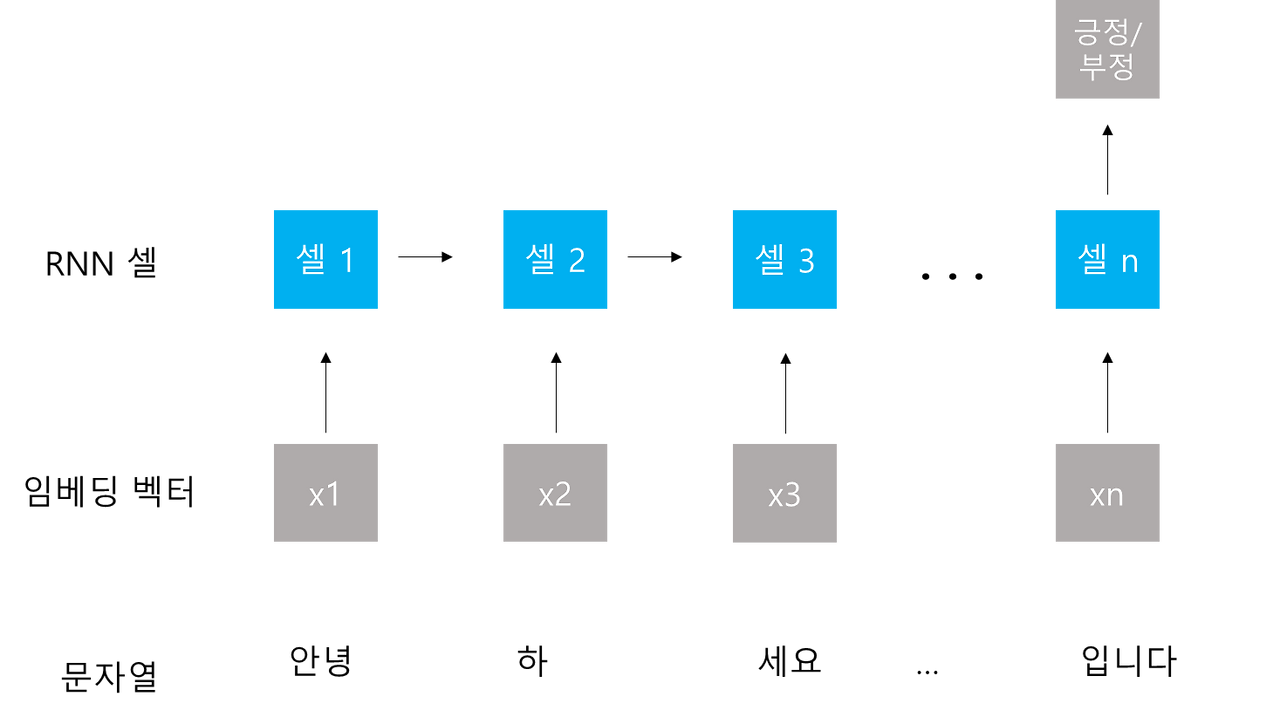

In [3]:
# 문장 분류 모델
from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        dropout=0.5,
        bidirectional=True,
        model_type="lstm"
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :] # 마지막 시점의 결과값만 분리해 분류기에 전달
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [4]:
#!pip install Korpora

In [5]:
# 데이터세트 로드
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
corpus_df = pd.DataFrame(corpus.test)

train = corpus_df.sample(frac=0.9, random_state=42)
test = corpus_df.drop(train.index)

print(train.head(5).to_markdown())
print("Training Data Size :", len(train))
print("Testing Data Size :", len(test))


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:00, 119MB/s]                             
[nsmc] download ratings_test.txt: 4.90MB [00:00, 61.0MB/s]


|       | text                                                                                     |   label |
|------:|:-----------------------------------------------------------------------------------------|--------:|
| 33553 | 모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만 영원하라. |       1 |
|  9427 | 무한 리메이크의 소재. 감독의 역량은 항상 그 자리에...                                    |       0 |
|   199 | 신날 것 없는 애니.                                                                       |       0 |
| 12447 | 잔잔 격동                                                                                |       1 |
| 39489 | 오랜만에 찾은 주말의 명화의 보석                                                         |       1 |
Training Data Size : 45000
Testing Data Size : 5000


In [6]:
#!pip install konlpy

In [7]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import Okt
from collections import Counter


def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    return vocab


tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in train.text]
test_tokens = [tokenizer.morphs(review) for review in test.text]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '.', '이', '영화', '의', '..', '가', '에', '...']
5002


문장의 길이를 맞추기 위해 \<pad> 토큰을 special_tokens에 추가했다.

In [8]:
# 정수 인코딩 및 패딩
import numpy as np


def pad_sequences(sequences, max_length, pad_value):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
    return np.asarray(result)


unk_id = token_to_id["<unk>"]
train_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in train_tokens
]
test_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in test_tokens
]

max_length = 32
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[ 223 1716   10 4036 2095  193  755    4    2 2330 1031  220   26   13
 4839    1    1    1    2    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[3307    5 1997  456    8    1 1013 3906    5    1    1   13  223   51
    3    1 4684    6    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


max_length는 입력 텍스트의 길이를 고려해 결정해야 한다.  
pad_sequences 함수는 시퀀스를 최대 길이로 잘라내고, 시퀀스 길이가 작으면 \<pad> 토큰을 시퀀스 뒤에 이어 붙여 동일한 길이로 변경한다.

In [9]:
# 데이터로더 적용
import torch
from torch.utils.data import TensorDataset, DataLoader


train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32)
test_labels = torch.tensor(test.label.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
# 손실 함수와 최적화 함수 정의
from torch import optim


n_vocab = len(token_to_id)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

BCEWithLogitsLoss 클래스는 BCELoss 클래스와 Sigmoid 클래스가 결합된 형태다.  
RMSprop은 모든 기울기를 누적하지 않고, 지수 가중 이동 평균을 사용해 학습률을 조정한다.

In [23]:
# 모델 학습 및 테스트
def train_loop(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")


def test_loop(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")


epochs = 5
interval = 500

for epoch in range(epochs):
    train_loop(classifier, train_loader, criterion, optimizer, device, interval)
    test_loop(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6822282075881958
Train Loss 500 : 0.6784542829333665
Train Loss 1000 : 0.6530484562510853
Train Loss 1500 : 0.6318983533515842
Train Loss 2000 : 0.6234749742354946
Train Loss 2500 : 0.6138442268566053
Val Loss : 0.622847254474323, Val Accuracy : 0.6726
Train Loss 0 : 0.587157130241394
Train Loss 500 : 0.5777837328330248
Train Loss 1000 : 0.5475322753339857
Train Loss 1500 : 0.5327053753575987
Train Loss 2000 : 0.5246425144512138
Train Loss 2500 : 0.5165981103460201
Val Loss : 0.45368190390614277, Val Accuracy : 0.7876
Train Loss 0 : 0.6481837034225464
Train Loss 500 : 0.4599330468389564
Train Loss 1000 : 0.4678605937070542
Train Loss 1500 : 0.4638618768045777
Train Loss 2000 : 0.4603250532009374
Train Loss 2500 : 0.4581374404508798
Val Loss : 0.43936514092710455, Val Accuracy : 0.7968
Train Loss 0 : 0.5108899474143982
Train Loss 500 : 0.4428673244254318
Train Loss 1000 : 0.44158539274980974
Train Loss 1500 : 0.43855118621972144
Train Loss 2000 : 0.43783123320948775
Tra

In [11]:
# 학습된 모델로부터 임베딩 추출
token_to_embedding = dict()
embedding_matrix = classifier.embedding.weight.detach().cpu().numpy()

for word, emb in zip(vocab, embedding_matrix):
    token_to_embedding[word] = emb

token = vocab[1000]
print(token, token_to_embedding[token])

보고싶다 [-0.75097096 -0.30146956 -2.6953852   0.21145868  1.9213923   0.10754307
  0.39919272  0.2885264   0.4548179   0.2786071   1.6747004  -0.2889332
 -1.035697   -0.31543943 -0.33854324  1.8467728  -0.25826463 -1.2920822
 -0.1893062  -1.0792567  -1.3411739   0.17573705  0.7511392   0.85222536
  0.0419251  -1.0852342  -1.254987    0.33618268  1.3278077  -0.13876496
 -0.4292601  -1.0168564  -0.43411875  1.5047382  -0.44934186 -0.46548596
  1.7834903   1.558458    0.32228556  0.10991768  1.5928614  -0.29889694
  0.66041875 -0.10638073 -1.2209449  -0.33702657  1.5383013   0.43689117
  0.38056278  1.6215843  -1.2989998  -0.84515786  0.63487595 -0.5171479
  0.5048      1.9599469   0.4301347  -1.6750007  -2.6383498  -0.41131434
  0.18739958 -0.3770897  -0.46619704  0.16037077  0.97234195  1.5776287
 -0.06806059 -0.7296294  -0.07085097  0.7874308   0.99599504 -0.664845
 -1.0512402  -0.31045458 -2.2437253  -0.39108384  0.96281666 -0.39810425
  0.43770474  0.11447162  0.09107163 -0.18034522 -0.

# 4. 사전 학습된 모델로 임베딩 계층 초기화

In [13]:
import pandas as pd
from Korpora import Korpora
from konlpy.tag import Okt


corpus = Korpora.load("nsmc")
corpus = pd.DataFrame(corpus.test)

tokenizer = Okt()
tokens = [tokenizer.morphs(review) for review in corpus.text]


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ra

In [ ]:
#!pip install gensim

In [16]:
from gensim.models import Word2Vec


word2vec = Word2Vec(
    sentences=tokens,
    vector_size=128,
    window=5,
    min_count=1,
    sg=1,
    epochs=3,
    max_final_vocab=10000
)

In [17]:
# 임베딩 계층 초기화
init_embeddings = np.zeros((n_vocab, embedding_dim))

for index, token in id_to_token.items():
    if token not in ["<pad>", "<unk>"]:
        init_embeddings[index] = word2vec.wv[token]

embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(init_embeddings, dtype=torch.float32)
)

In [18]:
# 문장 분류 모델
from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        dropout=0.5,
        bidirectional=True,
        model_type="lstm",
        pretrained_embedding=None # 사전 학습된 임베딩 사용 여부
    ):
        super().__init__()

        # 사전 학습된 임베딩 계층 적용
        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embedding, dtype=torch.float32)
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings=n_vocab,
                embedding_dim=embedding_dim,
                padding_idx=0
            )

        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [25]:
# 사전 학습된 임베딩을 사용한 모델 학습
classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim,
    n_layers=n_layers, pretrained_embedding=init_embeddings
).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

epochs = 5
interval = 500

for epoch in range(epochs):
    train_loop(classifier, train_loader, criterion, optimizer, device, interval)
    test_loop(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6943752765655518
Train Loss 500 : 0.6452803330388136
Train Loss 1000 : 0.5865790768787935
Train Loss 1500 : 0.5611813905078678
Train Loss 2000 : 0.5453773978753188
Train Loss 2500 : 0.5365648553794214
Val Loss : 0.46334300782924265, Val Accuracy : 0.776
Train Loss 0 : 0.38105636835098267
Train Loss 500 : 0.468767518292882
Train Loss 1000 : 0.4749707135704014
Train Loss 1500 : 0.4748234968634942
Train Loss 2000 : 0.47280956828582293
Train Loss 2500 : 0.4719223379254675
Val Loss : 0.44782873254995376, Val Accuracy : 0.7926
Train Loss 0 : 0.9067835807800293
Train Loss 500 : 0.45224050625772055
Train Loss 1000 : 0.4571321004411796
Train Loss 1500 : 0.45449767057237267
Train Loss 2000 : 0.45336029152090346
Train Loss 2500 : 0.4532797535965558
Val Loss : 0.4479099134572398, Val Accuracy : 0.781
Train Loss 0 : 0.439771831035614
Train Loss 500 : 0.451936843985331
Train Loss 1000 : 0.44146880593809573
Train Loss 1500 : 0.43741225245235604
Train Loss 2000 : 0.43668780226385157
T

사전 학습된 임베딩을 사용하는 것은 모델 성능을 개선할 수 있는 방법 중 하나다.  
하지만 학습 데이터의 양이 충분히 많아면, 모델의 목적에 맞게 새로운 임베딩 층을 학습하는 것이 더 좋을 수도 있다.  


또한, 사전 학습된 임베딩을 사용하더라도 해당 언어와 문제에 맞는 임베딩을 선택하는 것이 중요하다.  
ex) 한국어 NLP에서는 문맥 정보를 고려한 임베딩 방법이 더 성능이 좋을 수 있음.